In [1]:
import jax
jax.config.update("jax_compilation_cache_dir", "./jax-cache")
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update('jax_platforms', 'cpu')
import numpy as np
import functools

In [2]:
import matplotlib.pyplot as plt
from skimage.morphology import disk, rectangle
import itertools

In [3]:
import matplotlib.pyplot as plt
import sys 
sys.path.append('../plot_helpers/')
plt.style.use(['../plot_helpers/prl_paper.mplstyle'])
from plot_helper_for_paper import set_size, plot_imshow, plot_contourf

In [4]:
sys.path.append('../fft_helpers/')

from projection_operators import compute_Ghat_4_2
import tensor_operators as tensor

In this notebook, we implement the small-strain `J2` plasticity. We use the automatic differentiation to compute the alogriothmic tangent stiffness matrix (which ia function of bbothe elastic strain and plastic strain and yield function). It is necessary for `Newton-Raphson` iteration. 

## constructing an RVE

In [5]:
import random
random.seed(1)

def place_circle(matrix, n, r, x_center, y_center):
    for i in range(n):
        for j in range(n):
            if (i - x_center)**2 + (j - y_center)**2 <= r**2:
                matrix[i][j] = 1

def generate_matrix_with_circles(n, x, r):
    if r >= n:
        raise ValueError("Radius r must be less than the size of the matrix n")
        
    matrix = np.zeros((n, n), dtype=int)
    placed_circles = 0
    
    while placed_circles < x:
        x_center = random.randint(0, n-1)
        y_center = random.randint(0, n-1)
        
        # Check if the circle fits within the matrix bounds
        if x_center + r < n and y_center + r < n and x_center - r >= 0 and y_center - r >= 0:
            previous_matrix = matrix.copy()
            place_circle(matrix, n, r, x_center, y_center)
            if not np.array_equal(previous_matrix, matrix):
                placed_circles += 1

    return matrix

# Example usage
n = 199
x = 10
r = 20
structure = generate_matrix_with_circles(n, x, r)

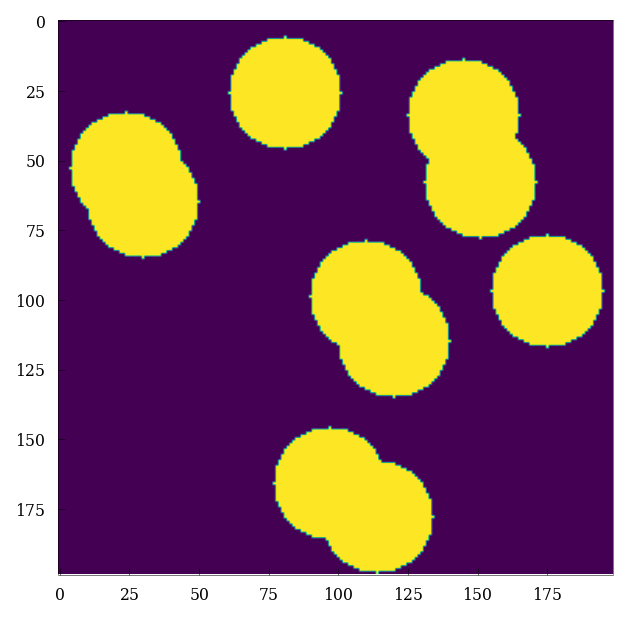

In [6]:
plt.imshow(structure)

In [7]:
ndim = len(structure.shape)
N = structure.shape[0]

# grid dimensions
shape = [
    N,
] * ndim  # number of voxels in all directions

We also define certain Identity tensor for each grid point.

- $\mathbf{I}$ = 2 order Identity tensor with shape `(2, 2, N, N)` 
- $\mathbb{I4}$ = 4 order Identity tensor with shape `(2, 2, 2, 2, N, N)`


## fft helpers and operators

In [8]:
# identity tensor (single tensor)
i = jnp.eye(ndim)

# identity tensors (grid)
I = jnp.einsum(
    "ij,xy",
    i,
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)  # 2nd order Identity tensor
I4 = jnp.einsum(
    "ijkl,xy->ijklxy",
    jnp.einsum("il,jk", i, i),
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)  # 4th order Identity tensor
I4rt = jnp.einsum(
    "ijkl,xy->ijklxy",
    jnp.einsum("ik,jl", i, i),
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)
I4s = (I4 + I4rt) / 2.0

II = tensor.dyad22(I, I)
I4d = I4s - II / 3.0

In [9]:
# (inverse) Fourier transform (for each tensor component in each direction)
@jax.jit
def fft(x):
    return jnp.fft.fftshift(jnp.fft.fftn(jnp.fft.ifftshift(x), [N, N]))


@jax.jit
def ifft(x):
    return jnp.fft.fftshift(jnp.fft.ifftn(jnp.fft.ifftshift(x), [N, N]))

The projection operator

In [10]:
Ghat4_2 = compute_Ghat_4_2(NN=(N,) * ndim, operator="fourier", length=1.0)

## assigning material parameters 
We assign material parameters to the two phases. The two phases within the RVE are denoted as
- Soft = 0
- Hard = 1

In [11]:
# material parameters + function to convert to grid of scalars
@functools.partial(jax.jit, static_argnames=["soft", "hard"])
def param(X, soft, hard):
    return hard * jnp.ones_like(X) * (X) + soft * jnp.ones_like(X) * (1 - X)

We consider a `linear isotropic hardening law` for both the phases

In [12]:
# material parameters
phase_constrast = 2

K = param(structure, soft=0.833, hard= phase_constrast*0.833)  # bulk      modulus
μ = param(structure, soft=0.386, hard= phase_constrast*0.386)  # shear     modulus
H = param(
    structure, soft=2000.0e6 / 200.0e9, hard=phase_constrast* 2000.0e6 / 200.0e9
)  # hardening modulus
sigma_y = param(
    structure, soft=600.0e6 / 200.0e9, hard=phase_constrast * 600.0e6 / 200.0e9
)  # initial yield stress

n = 1.

## plasticity basics

Now we define the basics of plasticity implementation:
- yield surface
  $$\Phi(\sigma_{ij}, \varepsilon^p_{ij}) = \underbrace{\sqrt{\dfrac{3}{2}\sigma^{dev}_{ij}\sigma^{dev}_{jk}}}_{\sigma^{eq}} - (\sigma_{0} + H\varepsilon^{p})$$
- return mappping algorithm
  $$\Delta \varepsilon =  \dfrac{\langle \Phi(\sigma_{ij}, \varepsilon_{p}) \rangle_{+}}{3\mu + H}$$
- tangent stiffness operator
  $$\mathbb{C} = \dfrac{\partial \sigma^{t+1}}{\partial \varepsilon^{t+1}} $$

In [13]:
@jax.jit
def yield_function(ep):
    return sigma_y + H*ep**n

In [14]:
@jax.jit
def sigma(eps_t, epse_t, ep_t, eps):

    # elastic stiffness tensor
    C4e = K * II + 2.0 * μ * I4d

    # trial state
    epse_s = epse_t + (eps - eps_t)
    sig_s = tensor.ddot42(C4e, epse_s)
    sigm_s = tensor.ddot22(sig_s, I) / 3.0
    sigd_s = sig_s - sigm_s * I
    sigeq_s = jnp.sqrt(3.0 / 2.0 * tensor.ddot22(sigd_s, sigd_s))

    # avoid zero division below ("phi_s" is corrected below)
    Z = jnp.where(sigeq_s == 0, True, False)
    sigeq_s = jnp.where(Z == True, 1, sigeq_s)

    # evaluate yield surface, set to zero if elastic (or stress-free)
    sigy = yield_function(ep_t)
    phi_s = sigeq_s - sigy
    phi_s = 1.0 / 2.0 * (phi_s + jnp.abs(phi_s))
    phi_s = jnp.where(Z == True, 0.0, phi_s)
    elastic_pt = jnp.where(phi_s <= 0, True, False)

    # plastic multiplier, based on non-linear hardening
    # - initialize
    dep = phi_s / (3 * μ + H)

    # return map algorithm
    N = 3.0 / 2.0 * sigd_s / sigeq_s
    ep = ep_t + dep
    sig = sig_s - dep * N * 2.0 * μ
    epse = epse_s - dep * N
    #jax.debug.print('x = {}', sig_s)
    
    return sig, epse, ep

## solution algorithm 

For Newton-Raphson iterations, 
\begin{align}
0 &= f(x) = f(x_0 + \Delta x) \\
  &= f(x_0) +  \underbrace{\dfrac{\partial f(x_0)}{\partial x} \Delta x}_{\Delta f} + O(|\Delta x|^2)
\end{align}

We compute directly the $\Delta f$ by using the `Jacobian-vector product`. Since are `sigma` function depends on various quantities, we make it a partial function and only evalute it for  $\Delta  \varepsilon$.
\begin{align}
 \Delta \sigma = \dfrac{\partial \sigma( \varepsilon, \varepsilon^{t}, \varepsilon_e^t, \varepsilon_p^t)}{\partial \varepsilon} \Delta \varepsilon
\end{align}

In [15]:
# functions for the projection 'G', and the product 'G : K : eps'
@jax.jit
def G(A2):
    return jnp.real(ifft(tensor.ddot42(Ghat4_2, fft(A2)))).reshape(-1)
    
@functools.partial(jax.jit, static_argnames=['sigma'])
def G_P(deps, additional, sigma):
    eps_t, epse_t, ep_t, eps = additional
    deps = deps.reshape(ndim,ndim,N,N)
    primal, tangents = jax.jvp(functools.partial(sigma, eps_t, epse_t, ep_t), (eps,), (deps,))
    return G(tangents[0])

## conjugate-gradient solver

In [16]:
@functools.partial(jax.jit, static_argnames=['A', 'K'])
def conjugate_gradient(A, b, additional, K,  atol=1e-5):

    b, additional = jax.device_put((b, additional))

    iiter = 0
        
    def true():
        return True
    def false():
        return False
        
    def body_fun(state):
        b, p, r, rsold, x, iiter =  state
        Ap = A(p, additional, K) 
        alpha = rsold / jnp.vdot(p, Ap)
        x = x + jnp.dot(alpha, p)
        r = r - jnp.dot(alpha, Ap)
        rsnew = jnp.vdot(r, r) 
        p = r + (rsnew/rsold)*p
        rsold = rsnew
        iiter = iiter + 1
        return (b, p, r, rsold, x, iiter)

    def cond_fun(state):
        b, p, r, rsold, x, iiter = state
        return  jax.lax.cond(jnp.logical_and(jnp.sqrt(rsold) > atol, iiter < 300), true, false)

    x = jnp.zeros_like(b)
    r = b - A(x, additional, K)
    p = r
    rsold = jnp.vdot(r, r) 
    
    b, p, r, rsold, x, iiter = jax.lax.while_loop(cond_fun, body_fun, (b, p, r, rsold, x, iiter) )
    return x, iiter

## newton-raphson method

In [17]:
@jax.jit
def solve_plasticity(state, n):
    deps, b, eps, eps_t, epse_t, ep_t, Fn, sig= state #, K4 = state

    error = jnp.linalg.norm(deps) / Fn
    jax.debug.print("residual={}", error)

    def true_fun(state):
        deps, b, eps, eps_t, epse_t, ep_t, Fn, sig = state #, K4 = state

        deps, iiter = conjugate_gradient(
            atol=1e-6,
            A=G_P, 
            b=b,
            additional= (eps_t, epse_t, ep_t, eps), 
            K =sigma,
        )  # solve linear system using CG

        deps = deps.reshape(ndim, ndim, N, N)
        eps = jax.lax.add(eps, deps)  # update DOFs (array -> tensor.grid)
        sig, epse, ep = sigma(eps_t, epse_t, ep_t, eps)
        b = -G(sig)  # compute residual

        jax.debug.print('CG iteration {}', iiter)

        return (deps, b, eps, eps_t, epse, ep, Fn, sig)#, K4)

    def false_fun(state):
        return state

    return jax.lax.cond(error > 1e-5, true_fun, false_fun, state), n

## solving rve problem for a loaded state

In [18]:
# initialize: stress and strain tensor, and history
sig = jnp.zeros([ndim, ndim, N, N], dtype="float64")
eps = jnp.zeros([ndim, ndim, N, N], dtype="float64")
eps_t = jnp.zeros([ndim, ndim, N, N], dtype="float64")
epse_t = jnp.zeros([ndim, ndim, N, N], dtype="float64")
ep_t = jnp.zeros([N, N], dtype="float64")

# define incremental macroscopic strain
ninc = 100
epsbar = 0.12
DE = jnp.zeros([ndim, ndim, N, N], dtype="float64")
DE = DE.at[0, 0].set(jnp.sqrt(3.0) / 2.0 * epsbar / float(ninc))
DE = DE.at[1, 1].set(-jnp.sqrt(3.0) / 2.0 * epsbar / float(ninc))

b = -G_P(DE,(eps_t, epse_t, ep_t, eps), sigma)
eps = jax.lax.add(eps, DE)
En = jnp.linalg.norm(eps)

In [19]:
state = (DE, b, eps, eps_t, epse_t, ep_t, En, sig)
state = jax.device_put(state)

In [20]:
import timeit

In [21]:
start_time = timeit.default_timer()

final_state, xs = jax.lax.scan(solve_plasticity, init=state, xs=jnp.arange(0, 10))

final_time = timeit.default_timer()
print(final_time-start_time)

residual=1.0
CG iteration 13
residual=0.3045565744948102
CG iteration 0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
2.6013770590070635


Now we plot the `plastic strain` and one the strain components $\varepsilon_{yy}$

In [22]:
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker

In [23]:
normal_plastic_strain = np.loadtxt('./additional_data/normal_plastic_strain.txt')
normal_epsilon_yy = np.loadtxt('./additional_data/normal_strain.txt')

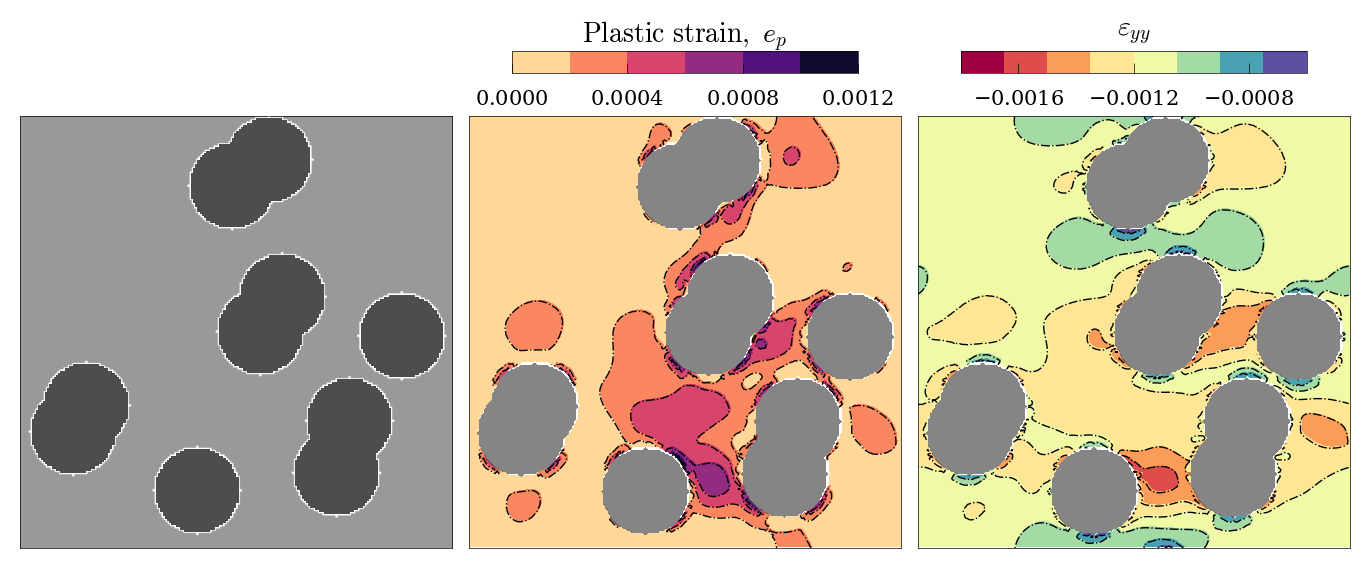

In [91]:
fig = plt.figure(figsize=set_size(width='two-column', fraction=0.95, height_ratio=0.45), 
                 constrained_layout=True, dpi=200)
gs1 = GridSpec(1, 3, figure=fig, width_ratios=[1, 1, 1])

ax = fig.add_subplot(gs1[0, 0])

ax.imshow(1-structure, alpha=0.4,  cmap='Greys', zorder=30, origin='lower')
ax.imshow(np.ma.array(structure[:, :], mask=1-structure), alpha=0.7,  cmap='Greys_r', zorder=30, origin='lower')

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(gs1[0, 1])

ax.contourf(np.ma.array(structure[:, :], mask=1-structure), alpha=0.7,  cmap='Greys_r', zorder=30)
#plot_contourf(fig=fig, ax=ax,
#            quantity=np.ma.array(final_state[5], mask=structure),
#            title=r'$\mathrm{Plastic~strain,}~e_p$', cmap='magma_r', levels=6)
title=r'$\mathrm{Plastic~strain,}~e_p$'
quantity = np.ma.array(final_state[5], mask=structure)
vmin = np.min(quantity)
vmax = np.max(quantity)
        
cs = ax.contourf(quantity, origin='lower', cmap='magma_r',  levels=6 )
cs2 = ax.contour(quantity, origin='lower', colors='k', levels=6, linestyles='dashdot',  linewidths=0.0001, alpha=0  )#, vmin=vmin, vmax=vmax, zorder=1, levels=8)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

axins1 = ax.inset_axes([0.1, 1.1, 0.8, 0.05])

cbar = fig.colorbar(cs, cax=axins1, pad=0.05, 
                      fraction=0.025, shrink=.5, orientation="horizontal")
tick_locator = ticker.MaxNLocator(nbins=3)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label(title, fontsize=10, labelpad=-32, y=0.85)
cbar.ax.yaxis.set_offset_position('right')  


CS=ax.contour(np.ma.array(normal_plastic_strain, mask=structure), alpha=1,  colors='k', zorder=30, linewidths=0.5, linestyles='dashdot', levels=cs2.levels[1:])
ax.set_aspect(1/ax.get_data_ratio())

ax = fig.add_subplot(gs1[0, 2])

ax.contourf(np.ma.array(structure[:, :], mask=1-structure), alpha=0.7,  cmap='Greys_r', zorder=30)
plot_contourf(fig=fig, ax=ax,
            quantity=np.ma.array(final_state[2].at[1, 1].get(), mask=structure),
            title=r'$\varepsilon_{yy}$', cmap='Spectral', levels=6)
ax.contour(np.ma.array(normal_epsilon_yy, mask=structure), alpha=1,  colors='black', zorder=30, linewidths=0.5, levels=6, linestyles='dashdot',)
ax.set_aspect(1/ax.get_data_ratio())

plt.savefig('./figs/paper_j2_plasticity.svg', dpi=200)
plt.show()